In [233]:
!pip install -qq tensorflow-datasets tensorflow matplotlib

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

2023-11-19 22:54:13.597239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# load the data from tfds
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

2023-11-19 22:54:15.196805: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/martin/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

2023-11-19 22:54:15.315578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-19 22:54:15.316050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-19 22:54:15.360532: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

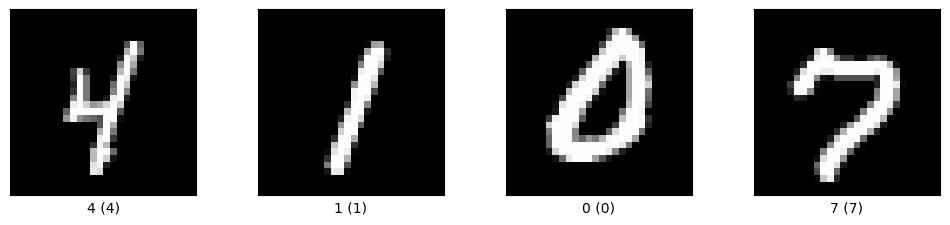

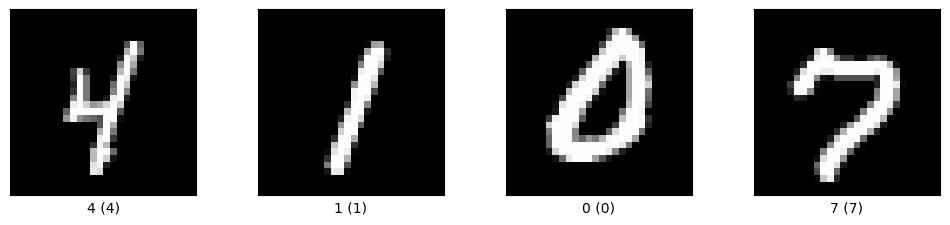

In [6]:
tfds.show_examples(train_ds, ds_info, rows=1, cols=4)

In [39]:
# data pipeline
def dataset(ds, mini_batch_size=512):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 128.0 - 1, y)) # normalize, 0~255 -> -1~1
    ds = ds.map(lambda x, y: (tf.reshape(x, (-1,)), y)) # flatten , 28x28 -> 784
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, 10))) # one-hot encoding
    ds = ds.shuffle(10000).batch(mini_batch_size) # shuffle and batch
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch with AUTOTUNE for performance

    return ds

In [ ]:
# # sanity check
# ds = dataset(train_ds)
# for elem in ds.take(1):
#     print(elem)

In [8]:
# simple model of feed-forward Dense layers
class Model(tf.keras.Model):
    """
    Create a simple feed-forward model with Dense layers.
    """
    def __init__(self, dense_layers, output_shape, layers_activation, output_activation):
        """
        args:
            dense_layers: list of int, number of neurons in each dense layer
            output_shape: int, number of neurons in the output layer
            layers_activation: str/activation function, activation function of the dense layers
            output_activation: str/activation function, activation function of the output layer
        """
        super(Model, self).__init__()
        self.__layers = []
        for layer in dense_layers:
            self.__layers.append(tf.keras.layers.Dense(layer, activation=layers_activation))
        self.__layers.append(tf.keras.layers.Dense(output_shape, activation=output_activation))

    def call(self, inputs):
        x = inputs
        for layer in self.__layers:
            x = layer(x)
        return x

In [9]:
from tqdm import tqdm

def training_loop(model, train, test, loss, opt, epochs=100):
    """
    Train the model with the given training and test datasets.
    args:
        model: tf.keras.Model, the model to train
        train: tf.data.Dataset, the training dataset
        test: tf.data.Dataset, the test dataset
        loss: tf.keras.losses, the loss function
        opt: tf.keras.optimizers, the optimizer
        epochs: int, number of epochs to train
    return:
        metrics: dict, training and test metrics
    """
    train_loss = tf.keras.metrics.Mean()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_loss = tf.keras.metrics.Mean()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()

    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    for epoch in tqdm(range(epochs), desc='Epochs'):
        for x, y in train:
            with tf.GradientTape() as tape:
                y_pred = model(x)
                loss_value = loss(y, y_pred)
            grads = tape.gradient(loss_value, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss(loss_value)
            train_accuracy(y, y_pred)
        
        for x, y in test:
            y_pred = model(x)
            loss_value = loss(y, y_pred)
            
            test_loss(loss_value)
            test_accuracy(y, y_pred)

        metrics['train_loss'].append(train_loss.result().numpy())
        metrics['train_accuracy'].append(train_accuracy.result().numpy())
        metrics['test_loss'].append(test_loss.result().numpy())
        metrics['test_accuracy'].append(test_accuracy.result().numpy())

        print(f'Train Loss: {metrics["train_loss"][-1]:.4f}, Train Accuracy: {metrics["train_accuracy"][-1]:.4f}')
        print(f'Test Loss: {metrics["test_loss"][-1]:.4f}, Test Accuracy: {metrics["test_accuracy"][-1]:.4f}')
        print()
    
    return metrics


In [49]:
import matplotlib.pyplot as plt
import json
import numpy as np

def save_metrics(model, metrics, hyper_parameter, file_name='metrics.json', model_description=""):
    """
    Save the metrics of the model to a json file.
    args:
        model: tf.keras.Model, the model to train
        metrics: dict, training and test metrics
        hyper_parameter: dict, hyper parameter of the model
        file_name: str, name of the json file
        model_description: str, description of the model
    """
    # round the measurmenrs to 4 decimal places
    for key, value in metrics.items():
        metrics[key] = [np.around(float(x), 4) for x in value]
    
    # add the number of parameters to the metrics
    params = model.count_params()

    # initialize the model info dict
    model_info = {
                "description": model_description ,
                "parameter_count": params,
                "hyper_parameter": hyper_parameter,
                "metrics": metrics,
                "accuracy_test": metrics['test_accuracy'][-1],
                "accuracy_train": metrics['train_accuracy'][-1],
                "loss_test": metrics['test_loss'][-1],
                "loss_train": metrics['train_loss'][-1],
                }
    
    # save the model info to a json file
    with open(file_name, 'w') as f:
        json.dump(model_info, f)

def load_metrics(file_name='metrics.json'):
    """
    Load the metrics of the model from a json file.
    """
    with open(file_name, 'r') as f:
        model_info = json.load(f)
    return model_info
    

def visualize(metrics, fig_title = "",max_steps = 20):

    # set the x-axis ticks
    epoch_idx = range(len(metrics['test_loss']))
    x_ticks = list(range(len(metrics['test_loss'])))
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]

    # Create a figure with two subplots (axes)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(fig_title)

    # Plot test loss and accuracy
    line3, = ax1.plot(metrics['test_loss'], 'r-')
    line4, = ax1.plot(metrics['train_loss'], 'b-')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend([line3, line4], ['Test Loss', 'Train Loss'])
    ax1.set_title('Loss, Train - Test')
    ax1.set_xticks(x_ticks)
    ax1.grid(True)

    # Plot training loss and accuracy
    line1, = ax2.plot(metrics['test_accuracy'], 'r--')
    line2, = ax2.plot(metrics['train_accuracy'], 'b--')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend([line1, line2], ['Test Accuracy', 'Train Accuracy'])
    ax2.set_title('Accuracy, Train - Test')
    ax2.set_xticks(x_ticks)
    ax2.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

def plot_model_comparision(models):
    """
    Plot the test accuracy of the given models.
    """
    fig , ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.suptitle("Model Comparision")


    if len(models) > 1:
        for model in models:
            model_info = load_metrics(model)
            model_metrics = model_info['metrics']
            # model_hyper_parameter = model_info['hyper_parameter']
            ax.plot(model_metrics['test_accuracy'], label=f"{model_info['description']}: {model_info['parameter_count']:,}")
    else:
        model_info = load_metrics(models)
        model_metrics = model_info['metrics']
        # model_hyper_parameter = model_info['hyper_parameter']
        ax.plot(model_metrics['test_accuracy'], label=f"{model_info['description']}: {model_info['parameter_count']:,}")

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

    plt.tight_layout()
    plt.show()

### Hyperparameters

In [86]:
class Model_Convolve(tf.keras.Model):
    """
    a simple CNN model with 2 Conv2D layers and 2 MaxPooling2D layers
    """
    def __init__(self):
        super(Model_Convolve, self).__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 28, 28, 1])
        return self.seq(x)

In [83]:
# configuration of the hyper parameters
DENSE_LAYERS = [16,16]
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MOMENTUM = 0.9
USE_SCHEDULER = True

train_data = dataset(train_ds, BATCH_SIZE)
test_data = dataset(test_ds, BATCH_SIZE)

In [84]:
# initialize the model
model = Model(DENSE_LAYERS, 10, 'relu', 'softmax')
# model = Model_Convolve()

loss = tf.keras.losses.CategoricalCrossentropy()
if USE_SCHEDULER:
    lr_fn = tf.optimizers.schedules.PolynomialDecay(LEARNING_RATE*0.1, EPOCHS, LEARNING_RATE*10, 2) # use a scheduler to decay the learning rate over time
    # opt = tf.keras.optimizers.SGD(learning_rate=lr_fn, momentum=MOMENTUM)
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
else:
    # opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [85]:
# train the modle and get the metrics of the training
metrics = training_loop(model, train_data, test_data, loss, opt, EPOCHS)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-19 23:44:10.478052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-11-19 23:44:10.479334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-19 23:44:18.533459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{n

Train Loss: 0.6664, Train Accuracy: 0.7937
Test Loss: 0.3552, Test Accuracy: 0.8991



Epochs:  20%|██        | 2/10 [00:17<01:08,  8.61s/it]

Train Loss: 0.4955, Train Accuracy: 0.8491
Test Loss: 0.3303, Test Accuracy: 0.9064



Epochs:  30%|███       | 3/10 [00:26<01:01,  8.75s/it]

Train Loss: 0.4263, Train Accuracy: 0.8711
Test Loss: 0.3133, Test Accuracy: 0.9117



Epochs:  40%|████      | 4/10 [00:34<00:52,  8.68s/it]

Train Loss: 0.3871, Train Accuracy: 0.8835
Test Loss: 0.3000, Test Accuracy: 0.9141



Epochs:  50%|█████     | 5/10 [00:43<00:43,  8.79s/it]

Train Loss: 0.3602, Train Accuracy: 0.8919
Test Loss: 0.2907, Test Accuracy: 0.9165



Epochs:  60%|██████    | 6/10 [00:52<00:35,  8.76s/it]

Train Loss: 0.3401, Train Accuracy: 0.8981
Test Loss: 0.2846, Test Accuracy: 0.9186



Epochs:  70%|███████   | 7/10 [01:01<00:26,  8.71s/it]

Train Loss: 0.3248, Train Accuracy: 0.9029
Test Loss: 0.2772, Test Accuracy: 0.9203



Epochs:  80%|████████  | 8/10 [01:09<00:17,  8.66s/it]

Train Loss: 0.3124, Train Accuracy: 0.9068
Test Loss: 0.2714, Test Accuracy: 0.9215



Epochs:  90%|█████████ | 9/10 [01:18<00:08,  8.74s/it]

Train Loss: 0.3023, Train Accuracy: 0.9099
Test Loss: 0.2653, Test Accuracy: 0.9231



Epochs: 100%|██████████| 10/10 [01:27<00:00,  8.72s/it]

Train Loss: 0.2934, Train Accuracy: 0.9128
Test Loss: 0.2620, Test Accuracy: 0.9240



In [87]:
print(model.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            multiple                  12560     
                                                                 
 dense_30 (Dense)            multiple                  272       
                                                                 
 dense_31 (Dense)            multiple                  170       
                                                                 
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
# save the metrics and model meta data to a json file
hyper_parameter = {
    'DENSE_LAYERS': DENSE_LAYERS,
    'EPOCHS': EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'LEARNING_RATE': LEARNING_RATE,
    'MOMENTUM': MOMENTUM,
    'USE_SCHEDULER': USE_SCHEDULER,
    'OPTIMIZER': 'Adam'
}

file_name = 'metrics_11.json'
model_description = f"Dense_{len(DENSE_LAYERS)}"
# model_description = "CNN_2Conv_2MaxPool_1Dense"
save_metrics(model, metrics, hyper_parameter, file_name ,model_description)

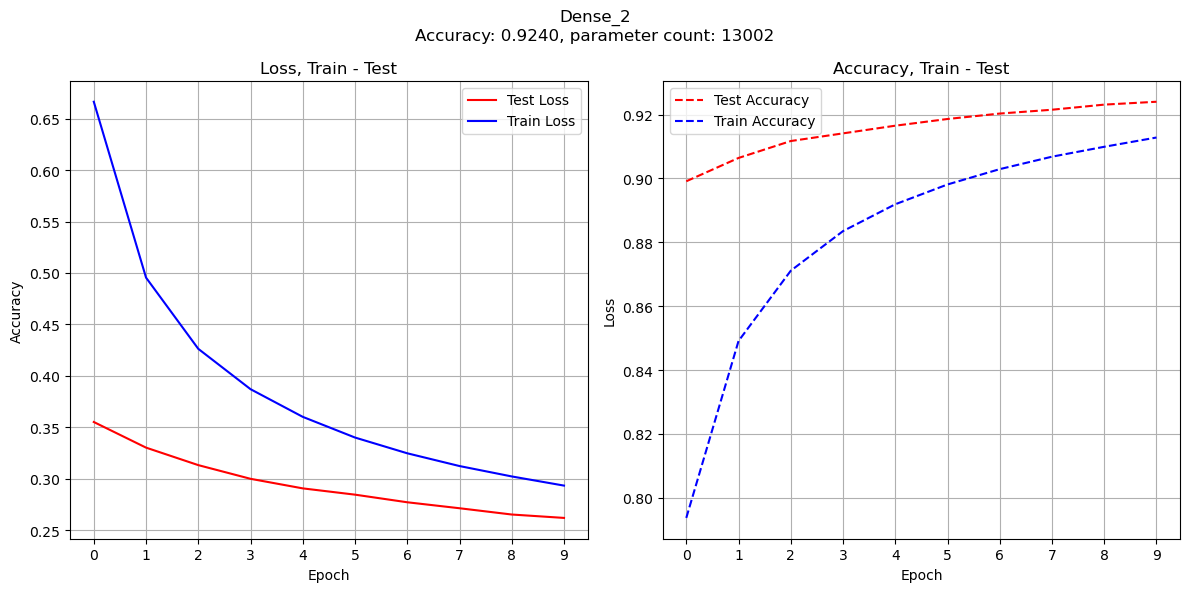

In [89]:
# visualize the metrics
with open(file_name, 'r') as f:
    model_info = json.load(f)

visualize(model_info['metrics'],
 f"{model_info['description']}\nAccuracy: {model_info['accuracy_test']:.4f}, parameter count: {model_info['parameter_count']}")


/tmp/ipykernel_67410/3864014859.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_entry_df], ignore_index=True)


                        model              layers #params     lr  momentum mini_batch epochs optimizer  accuracy_test  accuracy_train
0   CNN_2Conv_2MaxPool_1Dense                  []   71786  0.010       0.9        512     10      adam         0.9858          0.9825
4   CNN_2Conv_2MaxPool_1Dense                  []   71786  0.010       0.9        512     10       SGD         0.9850          0.9735
9                     Dense_3     [256, 128, 256]  269450  0.002       0.9        256     10      Adam         0.9672          0.9657
8                     Dense_4  [256, 128, 64, 32]  244522  0.001       0.9        512     10      Adam         0.9610          0.9553
7                     Dense_1                [64]   50890  0.010       0.5        128     10       SGD         0.9497          0.9434
5                     Dense_1               [128]  101770  0.010       0.9        512     10       SGD         0.9487          0.9459
2                     Dense_3       [128, 64, 32]  111146  0.0

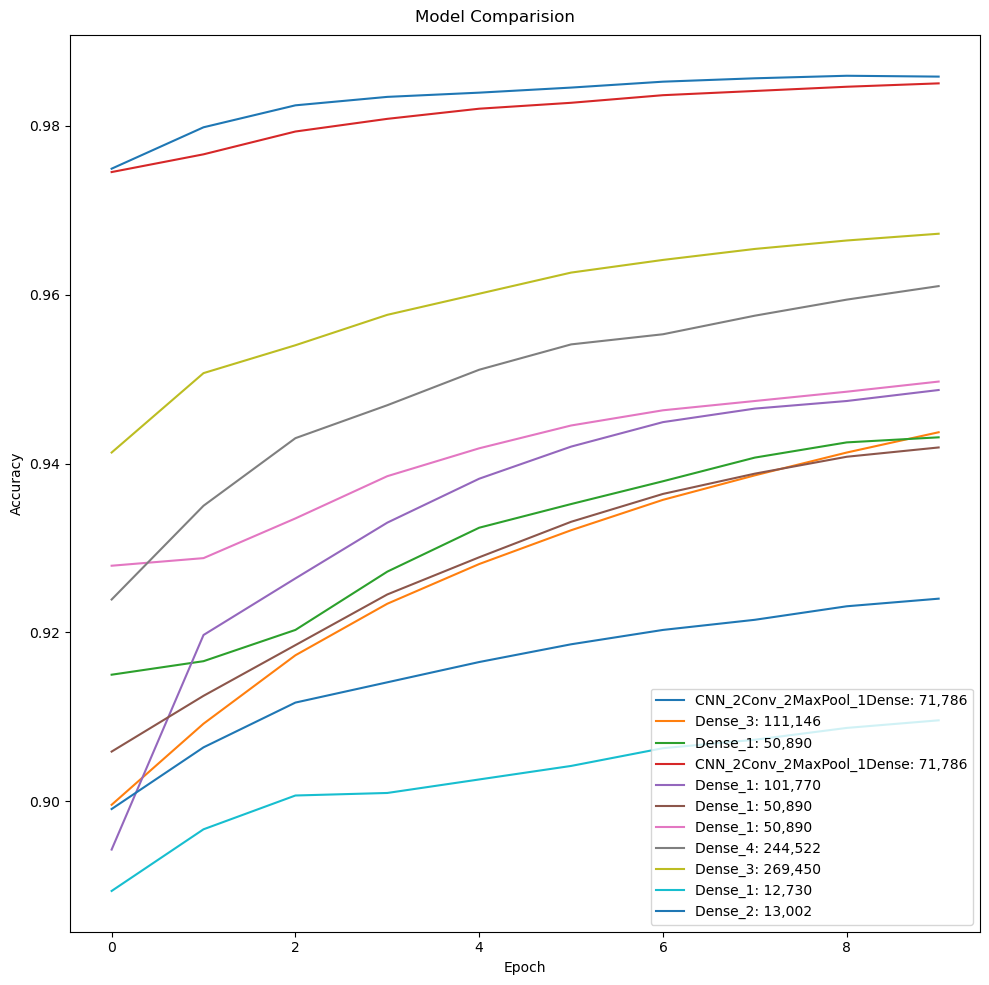

In [91]:
# compare multiple models from json files both tabularly and graphically
import pandas as pd

model_comparision = ["metrics_00.json","metrics_01.json",
                    "metrics_02.json", "metrics_03.json",
                    "metrics_04.json", "metrics_05.json",
                    "metrics_06.json", "metrics_07.json",
                    "metrics_08.json", "metrics_09.json",
                    "metrics_10.json", "metrics_11.json"]

# Define columns for the DataFrame
columns = ['model', 'layers', '#params', 'lr', 'momentum', 'mini_batch', 'epochs', 'optimizer', 'accuracy_test', 'accuracy_train']
df = pd.DataFrame(columns=columns)

for model in model_comparision:
    model_info = load_metrics(model)
    model_hyper_parameter = model_info['hyper_parameter']

    # Create a new entry as a dictionary ensuring all columns are covered
    new_entry = {
        'model': model_info['description'],
        'layers': model_hyper_parameter.get('DENSE_LAYERS', pd.NA),  # Using pd.NA for missing values
        '#params': model_info['parameter_count'],
        'lr': model_hyper_parameter.get('LEARNING_RATE', pd.NA),
        'momentum': model_hyper_parameter.get('MOMENTUM', pd.NA),
        'mini_batch': model_hyper_parameter.get('BATCH_SIZE', pd.NA),
        'epochs': model_hyper_parameter.get('EPOCHS', pd.NA),
        'optimizer': model_hyper_parameter.get('OPTIMIZER', pd.NA),
        'accuracy_test': model_info.get('accuracy_test', pd.NA),
        'accuracy_train': model_info.get('accuracy_train', pd.NA)
    }

    # Convert the dictionary to a DataFrame and concatenate
    new_entry_df = pd.DataFrame([new_entry], columns=columns)
    df = pd.concat([df, new_entry_df], ignore_index=True)

df = df.sort_values(by=['accuracy_test'], ascending=False)
print(df.to_string())

plot_model_comparision([model_comparision[0]] + model_comparision[2:])

### analysis of the results
for the analysis we will briefly discuss the results of the following 4 DenseNet models and the best performing model (CNN):
-All models were trained for 10 epochs

A - Denes - [64] neurons - LR: 0.01 - momentum: 0.5 - batch size: 128 - opt: SGD - params: 50890 
B - Dense - [64] neurons - LR: 0.01 - momentum: 0.5 - batch size: 256 - opt: SGD - params: 50890 
C - Dense - [16] neurons - LR: 0.001 - momentum: 0.9 - batch size: 64 - opt: Adam - params: 12730 
D - Dense - [128, 64, 32] neurons - LR: 0.01 - momentum: 0.9 - batch size: 256 - opt: SGD - params: 111146

- model A has performed better than larger models and same models with varient RL and momentum ( B and D and other similar ones) what sat it apart was the smaller batch size, which allowed for more frequent updates to the weights, where as model D proved to be too large for the learning rate of 0.01 on the given task, and could not converge at all, model C of only one hidden layer of 16 neurons proved to perform comparaply well with over 90% accuracy, and smaller batches proved better than larger ones, as well as smaller LR and higher momentum.

the closest we got to a CNN performance (98.5%) was with model A (95%), and next with condedirably larger moodels not included in the anaylsis above, [256, 128, 256] with (96.7%) ...